In [24]:
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from jax import jacfwd, jacrev
from jax import vmap, grad, jit, random
from jax.tree_util import tree_map, tree_flatten, tree_unflatten, tree_leaves

from flax import nnx
import optax
import pcax

from tqdm.notebook import tqdm
from tqdm.notebook import trange

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import os
os.chdir('../methods')
import lsci, supr, conf, uqno, prob_don, quant_don, gaus
os.chdir('../gpsims')

os.chdir('../models_and_metrics')
from models import *
from metrics import * 
from utility import *
os.chdir('../gpsims')

import neuralop as op
from neuralop.models import FNO, LocalFNO, UNO, TFNO
import jaxwt as jwt
import pcax
from jax.scipy.stats import norm, laplace

In [84]:
def phi_depth(z, x, w, depth_fn):
    if depth_fn == 'tukey':
        f = jnp.sum(w[:,None] * (z > x), axis = 0)
        depth_1d = 1 - jnp.abs(1 - 2 * f)
    
    elif depth_fn == 'mahal':
        mu = jnp.sum(w[:,None]*x, axis = 0)
        sig = jnp.sqrt(jnp.sum((w[:,None]*x - mu)**2, axis = 0))
        depth_1d = 1/(1+jnp.sqrt((z - mu)**2/sig**2))
        
    elif depth_fn == 'norm':
        norms = jnp.abs(z - x)
        wnorm = jnp.sum(w[:,None] * norms, axis = 0)
        depth_1d = 1/(1+wnorm)

    else: return 0
    return jnp.min(depth_1d)

phi_depth = jit(phi_depth, static_argnames='depth_fn')
vphi_depth = jit(vmap(phi_depth, (0, None, None, None)), static_argnames='depth_fn')

def phi_slice(rng, p1, p2):
    phi = random.normal(rng, (p1, p2))
    phi = phi / jnp.sum(phi, axis = 1)[:,None]
    return phi

def lweights(xval, xtest, frac = 0.1):
    dmat = jnp.max(jnp.abs(xval - xtest), axis = 1)
    quant = jnp.quantile(dmat, frac, axis = 0)
    indx = dmat < quant
    inner_max = jnp.max(dmat * indx)
    dmat = inner_max - dmat
    w = dmat * indx
    return w / jnp.sum(w, axis = 0)[None,]
lweights = jit(vmap(lweights, (None, 0, None)))


def localizer(xval, xtest, lam, local_fn, rng):
    if local_fn == 'dexp':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.exp(-lam * jnp.max(jnp.abs(xval - xtil), axis = (1, 2)))
        local_weights = dist / (jnp.sum(dist) + jnp.exp(-lam * 1e-2))
        
    elif local_fn == 'gaussian':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.exp(-lam * jnp.mean((xval - xtil)**2, axis = (1, 2)))
        local_weights = dist / (jnp.sum(dist) + jnp.exp(-lam * 1e-2))
        
    elif local_fn == 'knn':
        xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
        dist = jnp.max(jnp.abs(xval - xtil), axis = (1, 2))
        qdist = jnp.quantile(dist, lam)
        dist = jnp.exp(-dist.at[dist > qdist].set(jnp.inf))
        local_weights = dist / (jnp.sum(dist) + 1)
        
    else :
        local_weights = 1/xval.shape[0]
    return local_weights

def phi_quantile(rval_phi, xval, xtest, alpha, depth_fn, local_fn, lam, rng):
    
#     xtil = xtest[None,] + 1e-2 * jax.random.normal(rng, xtest[None,].shape)
#     dist = jnp.exp(-lam * jnp.max(jnp.abs(xval - xtil), axis = (1, 2)))
#     local_weights = dist / (jnp.sum(dist) + jnp.exp(-lam * 1e-2))

    local_weights = localizer(xval, xtest, lam, local_fn, rng)
    dval = vphi_depth(rval_phi, rval_phi, local_weights, depth_fn)
    
    n = xval.shape[0]
    adj_alpha = jnp.ceil((n+1)*(1-alpha))/n
    return jnp.quantile(dval, 1-adj_alpha), local_weights
# phi_quantile = jit(phi_quantile, static_argnames=['depth_fn', 'local_fn'])


def phi_resample(xval, xtest, rval_phi, n_samp, n_slice, rng,
                 alpha, depth_fn, local_fn, lam):
    n = rval_phi.shape[0]
    npc = rval_phi.shape[1]
    key1, key2, key3 = random.split(rng, 3)
    local_weights = lweights(xval.squeeze(), xtest.squeeze()[None,], 0.1)[0]
    
    unif = random.uniform(key1, (n_samp, npc))
    quants = jnp.linspace(jnp.min(rval_phi) - 0.1, jnp.max(rval_phi) + 0.1, n+1)

    samp_cdfs = lsci.lcdf(rval_phi, quants, local_weights / jnp.sum(local_weights))
    samp_quants = jnp.argmax(samp_cdfs[:,:,None] > unif.T[None,:,:], axis = 0)
    samp_phi = quants[samp_quants].T
    
    phi = phi_slice(key2, npc, n_slice)
    qval, local_weights = phi_quantile(rval_phi @ phi, xval, xtest, alpha, depth_fn, local_fn, lam, rng = key3)
    dphi = vphi_depth(samp_phi @ phi, rval_phi @ phi, local_weights, depth_fn)
    
    return samp_phi, dphi, qval

In [75]:
def uqno_lambda(yval, yval_hat, yval_quant, delta, alpha):
    n = yval.shape[0]
    m = yval.shape[2]
    tau = 1e-2 + jnp.sqrt(-jnp.log(delta)/(2*m))
    
    uqno_scores = jnp.abs(yval.squeeze() - yval_hat) / yval_quant
    sg = jnp.quantile(uqno_scores, jnp.clip(1-alpha+tau, 0, 1), axis = 1)
    q = 1 - jnp.ceil((n+1)*(delta - jnp.exp(-2*m*tau**2)))/n
    return jnp.quantile(sg, q)

def prob_don(yval, yval_mu, yval_sd, ytest_sd, alpha):
    nval = yval.shape[0]
    alpha_adj = jnp.ceil((1-alpha) * (nval + 1))/nval
    
    score = jnp.abs(yval - yval_mu)/yval_sd
    q = jnp.quantile(score, alpha_adj, axis = 0)
    
    lower = -ytest_sd * q[None,]
    upper = ytest_sd * q[None,]
    return lower, upper

def quant_don(yval, yval_quant, ytest_quant, alpha):
    
    nval = yval.shape[0]
    alpha_adj = jnp.ceil((1-alpha) * (nval + 1))/nval
    
    lower = -yval_quant - yval
    upper = yval - yval_quant
    score = jnp.max(jnp.stack([lower, upper], axis = 2), axis=2)
    q = jnp.quantile(score, alpha_adj, axis = 0)
    
    lower = -ytest_quant - q[None,]
    upper = ytest_quant + q[None,]
    return lower, upper

In [76]:
class QuantileLoss(nn.Module):
    def __init__(self, quantile):
        super().__init__()
        self.quantile = quantile

    def forward(self, y_hat, y):
        res = y - y_hat
        return torch.mean(torch.max((self.quantile - 1) * res, self.quantile * res))
    
class GaussianNLLLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, y):
        mu, sd = outputs
        nll = 0.5 * torch.log(2 * torch.pi * sd**2) + 0.5*(y - mu)**2 / sd**2
        return nll.mean()
    
class ProbFNO(nn.Module):
    def __init__(self):
        super().__init__()
        self.mu_fno = FNO(n_modes=(16,), hidden_channels=64, in_channels=1, out_channels=1)
        self.sd_fno = FNO(n_modes=(16,), hidden_channels=64, in_channels=1, out_channels=1)

    def __call__(self, x):
        mu = self.mu_fno(x)
        log_sd = self.sd_fno(x)
        return mu, torch.nn.Softplus()(log_sd)

In [77]:
def clocktime():
    hours = []
    for i in range(24):
        j = i
        if i % 12 == 0: j = 12

        if i < 12:
            hours.append(f'{j} ' + 'AM') 
        elif i == 12:
            hours.append(f'{j} ' + 'PM') 
        else:
            hours.append(f'{j-12} ' + 'PM')
    return hours

In [78]:
import pandas as pd
# energy = pd.read_excel('../data/Region_TEX.xlsx')
energy = pd.read_excel('../data/tx_energy.xlsx')

In [79]:
energy_curves =  energy.groupby('Local date')['Demand'].apply(list).reset_index()
energy_curves = np.array(energy_curves)

dts = energy_curves[:,0]
fns = energy_curves[:,1]

# # transform
fns = [jnp.array(f) for f in fns]
fns = [jax.image.resize(f, (24,), 'bicubic') for f in fns]
fns = np.array(fns)

# backfill missing
missing = jnp.sum(jnp.isnan(fns), axis = 1) > 0
for i in range(fns.shape[0]):
    if missing[i]:
        fns[i] = fns[i-1]

# rescale
# fns = (fns - jnp.mean(fns, axis = 0)[None,:]) / jnp.std(fns, axis = 0)[None,:]
energy_mean, energy_std =  jnp.mean(fns, axis = 1)[:,None], jnp.std(fns, axis = 1)[:,None]
fns0 = fns.copy()
fns = (fns - energy_mean) / energy_std
fns = jnp.array(fns)

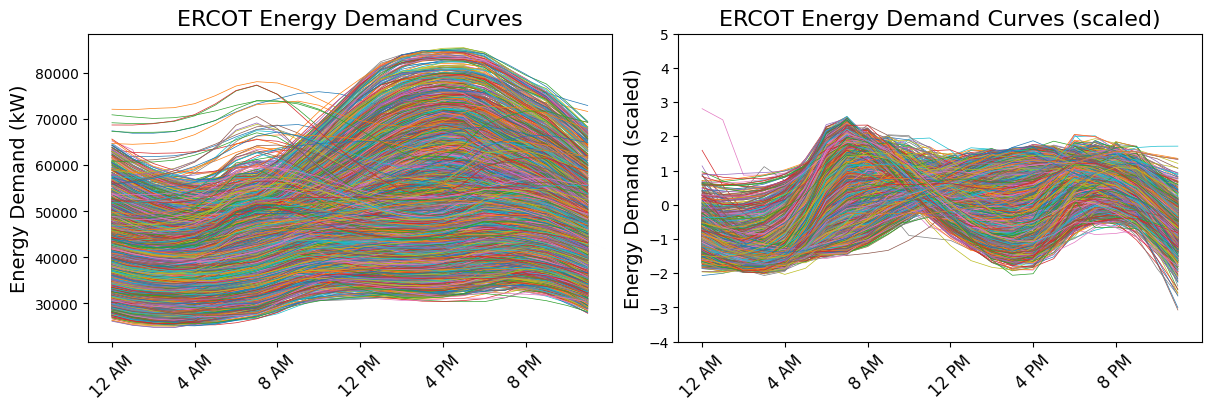

In [80]:
### examples
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (12, 4))

hours = clocktime()
s = np.arange(24)

# ax[0].set_ylim(-4, 5)
ax[0].plot(fns0.T, lw = 0.5)
ax[0].set_xticks(s[::4], hours[::4], rotation=45, fontsize = 12)
ax[0].set_ylabel('Energy Demand (kW)', fontsize = 14)
ax[0].set_title(f'ERCOT Energy Demand Curves', fontsize = 16)

ax[1].set_ylim(-4, 5)
ax[1].plot(fns.T, lw = 0.5)
ax[1].set_xticks(s[::4], hours[::4], rotation=45, fontsize = 12)
ax[1].set_ylabel('Energy Demand (scaled)', fontsize = 14)
ax[1].set_title(f'ERCOT Energy Demand Curves (scaled)', fontsize = 16)
plt.show()

In [81]:
lag = 1
lead = 1
x, y = split_data(fns, lag, 1)
ntrain, nval = 1500, 2500

xtrain = x[:ntrain].reshape(-1, lag, 24)
ytrain = y[:ntrain].reshape(-1, lead, 24)

xval = x[ntrain:nval].reshape(-1, lag, 24)
yval = y[ntrain:nval].reshape(-1, lead, 24)

xtest = x[nval:].reshape(-1, lag, 24)
ytest = y[nval:].reshape(-1, lead, 24)

train_data = TensorDataset(torch.Tensor(np.array(xtrain)), torch.Tensor(np.array(ytrain)))
train_loader = DataLoader(train_data, batch_size = 30, shuffle = True)

In [43]:
loss_fn = nn.MSELoss()

fno = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
optim_fno = torch.optim.Adam(fno.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()
        
with torch.no_grad():
    yval_fno = jnp.array(np.array(fno(jax2torch(xval)).squeeze()))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [44]:
loss_fn = QuantileLoss(0.9)

fno_quant = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
optim_fno = torch.optim.Adam(fno_quant.parameters(), lr = 1e-3)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno_quant(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()
        
with torch.no_grad():
    yval_quant = jnp.array(np.array(fno_quant(jax2torch(xval)).squeeze()))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [45]:
loss_fn = GaussianNLLLoss()

fno_prob = ProbFNO()
optim_fno = torch.optim.Adam(fno_prob.parameters(), lr = 1e-3)

for _ in trange(epochs):
    for xt, yt in tqdm(train_loader, leave = False):  
        yhat = fno_prob(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()
    
with torch.no_grad():
    yval_mu, yval_sd = jnp.array(np.array(fno_prob(jax2torch(xval))))
    yval_mu = yval_mu.squeeze()
    yval_sd = yval_sd.squeeze()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [50]:
## train
xtrain_base1 = xtrain[:(ntrain//2)]
ytrain_base1 = ytrain[:(ntrain//2)]
xtrain_base2 = xtrain[(ntrain//2):]
ytrain_base2 = ytrain[(ntrain//2):]

In [51]:
train_data1 = TensorDataset(jax2torch(xtrain_base1), jax2torch(ytrain_base1))
train_loader1 = DataLoader(train_data1, batch_size = 30, shuffle = True)

loss_fn = nn.MSELoss()
fno_base = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
optim_fno = torch.optim.Adam(fno_base.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader1, leave = False):  
        yhat = fno_base(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()
        
with torch.no_grad():
    ytrain_base1_hat = jnp.array(np.array(fno_base(jax2torch(xtrain_base2))))
    
train_data2 = TensorDataset(jax2torch(xtrain_base2), torch.abs(jax2torch(ytrain_base2 - ytrain_base1_hat)))
train_loader2 = DataLoader(train_data2, batch_size = 30, shuffle = True)

loss_fn = QuantileLoss(0.9)
fno_quant2 = FNO(n_modes=(16,), 
             hidden_channels=64, 
             in_channels=1, 
             out_channels=1)
optim_fno = torch.optim.Adam(fno_quant2.parameters(), lr = 1e-3)

epochs = 20
for _ in trange(epochs):
    for xt, yt in tqdm(train_loader2, leave = False):  
        yhat = fno_quant2(xt)
        loss = loss_fn(yhat, yt)
        loss.backward()
        optim_fno.step()
        optim_fno.zero_grad()
        
with torch.no_grad():
    yval_hat2 = jnp.array(np.array(fno_base(jax2torch(xval)).squeeze()))
    yval_quant2 = jnp.array(np.array(fno_quant2(jax2torch(xval)).squeeze()))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [52]:
## test
with torch.no_grad():
    ytest_fno = jnp.array(np.array(fno(jax2torch(xtest)).squeeze()))
    ytest_quant = jnp.array(np.array(fno_quant(jax2torch(xtest)).squeeze()))
    ytest_quant2 = jnp.array(np.array(fno_quant2(jax2torch(xtest)).squeeze()))
    
    ytest_mu, ytest_sd = jnp.array(np.array(fno_prob(jax2torch(xtest))))
    ytest_mu = ytest_mu.squeeze()
    ytest_sd = ytest_sd.squeeze()

rval_fno = yval.squeeze() - yval_fno
rtest_fno = ytest.squeeze() - ytest_fno

In [91]:
nproj = 100
nsamp = 2000
alpha = 0.1

# setup
pca_state = pcax.fit(rval_fno, nproj)
phi = phi_slice(random.PRNGKey(0), rval_fno.shape[1], nproj)
rval_phi = rval_fno @ phi
rval_fpc = pcax.transform(pca_state, rval_fno)

rval_quant = jnp.abs(rval_fno) / yval_quant

conf_lower, conf_upper = conf.conf_band(rval_fno, pca_state, alpha)
gaus_lower, gaus_upper = gaus.gaus_band(rval_fno, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval_fno, alpha)

uqno_lam = uqno_lambda(yval, yval_hat2, yval_quant2, delta = 0.1, alpha = 0.1)
uqn1_lower, uqn1_upper = -uqno_lam*ytest_quant2, uqno_lam*ytest_quant2

pdon_lower, pdon_upper = prob_don(yval.squeeze(), yval_mu, yval_sd, ytest_sd, alpha)
qdon_lower, qdon_upper = quant_don(yval.squeeze(), yval_quant, ytest_quant, alpha)

In [145]:
ntest = ytest.shape[0]
nmod = 2 + 6
cover = np.zeros((ntest, nmod))
width = np.zeros((ntest, nmod))

for k in trange(0, ntest):
    
    ## LSCI 1
    rng, key1, key2 = random.split(rng, 3)
    local_ens, dphi, qval = phi_resample(xval, xtest[k], rval_fpc, 
                                         nsamp, nproj, key1,
                                         alpha, 'tukey', 'dexp', 10)
    local_ens = pcax.recover(pca_state, local_ens)
    local_ens = local_ens[dphi > qval]

    uval = jnp.max(local_ens, axis = 0)
    lval = jnp.min(local_ens, axis = 0)
    cover[k, 0] = risk(lval, uval, rtest_fno[k])
    width[k, 0] = np.median(uval - lval)
    
    ## LSCI 2
    local_ens, dphi, qval = phi_resample(xval, xtest[k], rval_fpc, 
                                         nsamp, nproj, key1,
                                         alpha, 'tukey', 'gaussian', 10)
    local_ens = pcax.recover(pca_state, local_ens)
    local_ens = local_ens[dphi > qval]

    uval = jnp.max(local_ens, axis = 0)
    lval = jnp.min(local_ens, axis = 0)
    cover[k, 1] = risk(lval, uval, rtest_fno[k])
    width[k, 1] = np.median(uval - lval)
    
    # CONF 
    cover[k, 2] = risk(conf_lower, conf_upper, rtest_fno[k])
    width[k, 2] = jnp.median(conf_upper - conf_lower)
    
    # GAUSS 
    cover[k, 3] = risk(gaus_lower, gaus_upper, rtest_fno[k])
    width[k, 3] = jnp.median(gaus_upper - gaus_lower)
    
    # SUPR
    cover[k, 4] = risk(supr_lower, supr_upper, rtest_fno[k])
    width[k, 4] = jnp.median(supr_upper - supr_lower)
    
    # UQNO
    cover[k, 5] = risk(uqn1_lower[k], uqn1_upper[k], rtest_fno[k])
    width[k, 5] = jnp.median(uqn1_upper[k] - uqn1_lower[k])
    
    # PDON
    cover[k, 6] = risk(pdon_lower[k], pdon_upper[k], rtest_fno[k])
    width[k, 6] = jnp.median(pdon_upper[k] - pdon_lower[k])
    
    # QDON
    cover[k, 7] = risk(qdon_lower[k], qdon_upper[k], rtest_fno[k])
    width[k, 7] = jnp.median(qdon_upper[k] - qdon_lower[k])

  0%|          | 0/1021 [00:00<?, ?it/s]

In [146]:
np.mean(cover > 0.99, axis = 0), np.mean(width, axis = 0)

(array([0.90695397, 0.90891283, 0.94711068, 0.9324192 , 0.89813908,
        0.98824682, 0.3712047 , 0.78354554]),
 array([1.54400506, 1.54299906, 2.45086598, 2.20021868, 2.13037944,
        3.55247247, 0.81783259, 2.7447439 ]))

In [147]:
sigma = jnp.mean(rtest_fno**2, axis =1)

In [148]:
# metrics

cover_mean = np.round(np.mean(cover > 0.99, axis = 0), 3)
# cover_std = np.round(2*np.std(np.mean(cover > 0.99, axis = 0), axis = 1), 2)
width_mean = np.round(np.mean(width, axis = 0), 3)
# width_std = np.round(2*np.std(np.mean(width, axis = 0), axis = 1), 3)

## correlations
cover_corr_mean = np.zeros(nmod)
cover_corr_std = np.zeros(nmod)
width_corr_mean = np.zeros(nmod)
width_corr_std = np.zeros(nmod)
for i in range(nmod):
    corr = np.corrcoef(np.vstack([cover[:,i] > 0.99, sigma]))[0,1]
    cover_corr_mean[i] = np.mean(corr)
#     cover_corr_std[i] = 2*np.std(corr)
    
    corr = np.corrcoef(np.vstack([width[:,i], sigma]))[0,1]
    width_corr_mean[i] = np.mean(corr)
    width_corr_std[i] = 2*np.std(corr)

metrics_mean = np.vstack([
    cover_mean,
    cover_corr_mean,
    width_mean,
    width_corr_mean
]).T

# metrics_std = np.vstack([
#     cover_std,
#     cover_corr_std,
#     width_std,
#     width_corr_std
# ]).T

/Users/trevorharris/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/trevorharris/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [149]:
for i in range(nmod):
    for j in range(4):
        spacer = '& ' if j < 3 else '\\\\'
        endline = '' if j < 3 else '\n'
        
        result = metrics_mean[i, j]
        met = f'{result:.3f}' if not np.isnan(result) else '--'
        print(met, spacer, end=endline)

0.907 & -0.576 & 1.544 & 0.429 \\
0.909 & -0.564 & 1.543 & 0.429 \\
0.947 & -0.757 & 2.451 & -- \\
0.932 & -0.758 & 2.200 & -- \\
0.898 & -0.741 & 2.130 & -- \\
0.988 & -0.257 & 3.552 & 0.501 \\
0.371 & -0.203 & 0.818 & 0.487 \\
0.784 & -0.400 & 2.745 & 0.059 \\


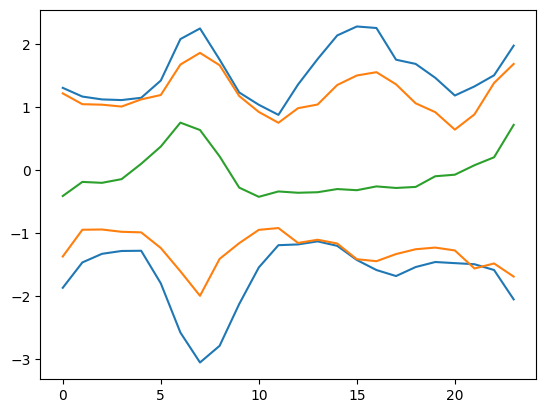

In [133]:
k = 600
rng, key1, key2 = random.split(rng, 3)
local_ens, dphi, qval = phi_resample(xval, xtest[k], rval_fpc, 
                                     nsamp, nproj, key1,
                                     alpha, 'tukey', 'knn', 0.1)
local_ens = pcax.recover(pca_state, local_ens)
local_ens = local_ens[dphi > qval]

uval = jnp.max(local_ens, axis = 0)
lval = jnp.min(local_ens, axis = 0)

state = lsci.lsci_state(xval, rval_fno, nproj)
lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[k].squeeze(), state, alpha, 5000, 0.1)

plt.plot(lsc1_upper, c = 'C0')
plt.plot(lsc1_lower, c = 'C0')
plt.plot(uval, c = 'C1')
plt.plot(lval, c = 'C1')

plt.plot(rtest_fno[k], c = 'C2')

In [7]:
epochs = 50
trace = []
lag, lead = 1, 1

width = 50
drop_prob = 0.1

rng = random.PRNGKey(0)
model_rng = nnx.Rngs(0)
base_model = DeepANO(lag, width, lead, rngs=model_rng)
drop_model = DropANO(lag, width, lead, drop_prob, rngs=model_rng)
prob_model = ProbANO(lag, width, lead, rngs=model_rng)
quant_model = DeepANO(lag, width, lead, rngs=model_rng)

base_optim = nnx.Optimizer(base_model, optax.adam(1e-3))
drop_optim = nnx.Optimizer(drop_model, optax.adam(1e-3))
prob_optim = nnx.Optimizer(prob_model, optax.adam(1e-3))
quant_optim = nnx.Optimizer(quant_model, optax.adam(1e-3))

for _ in trange(epochs):
    for xt, yt in train_loader:
        xt = torch2jax(xt)
        yt = torch2jax(yt)
        
        base_loss = train_step(base_model, base_optim, xt, yt)
        drop_loss = train_step(drop_model, drop_optim, xt, yt)
        prob_loss = prob_step(prob_model, prob_optim, xt, yt)
        quant_loss = quant_step(quant_model, quant_optim, xt, yt)

  0%|          | 0/50 [00:00<?, ?it/s]

In [8]:
yval_hat = base_model(xval)
ytest_hat = base_model(xtest)

yval_quant = quant_model(xval)
ytest_quant = quant_model(xtest)

yval_mu, yval_sd = prob_model(xval)
ytest_mu, ytest_sd = prob_model(xtest)

In [9]:
yval = yval.squeeze()
ytest = ytest.squeeze()

yval_hat = yval_hat.squeeze()
ytest_hat = ytest_hat.squeeze()
yval_quant = yval_quant.squeeze()
ytest_quant = ytest_quant.squeeze()
yval_mu = yval_mu.squeeze()
yval_sd = yval_sd.squeeze()
ytest_mu = ytest_mu.squeeze()
ytest_sd = ytest_sd.squeeze()

In [10]:
# nproj = npc = 24
# gamma1 = 0.1
# gamma2 = 0.05
# alpha = 0.1
# nval = xval.shape[0]

# drop_risk, drop_width = [], []
# orcl_risk, orcl_width = [], []
# conf_risk, conf_width = [], []
# gaus_risk, gaus_width = [], []
# supr_risk, supr_width = [], []
# uqn1_risk, uqn1_width = [], []
# pdon_risk, pdon_width = [], []
# qdon_risk, qdon_width = [], []
# lsc1_risk, lsc1_width = [], []
# lsc2_risk, lsc2_width = [], []

# rval = (yval - yval_hat).squeeze()
# rtest = (ytest - ytest_hat).squeeze()
# rtest2 = (ytest - ytest_mu).squeeze()

# state = lsci.lsci_state(xval, rval, npc)
# pca_state = state[-1]

# quant_scores = jnp.abs(yval - yval_hat) / yval_quant
# lam_uqno = uqno.estimate_lambda(quant_scores, 0.1, 0.01, 1.1)

# conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
# gaus_lower, gaus_upper = gaus.gaus_band(rval, pca_state, alpha)
# supr_lower, supr_upper = supr.supr_band(rval, alpha)
# uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)
# pdon_lower, pdon_upper = prob_don.prob_don(prob_model, xval, xtest, yval, alpha)
# qdon_lower, qdon_upper = quant_don.quant_don(quant_model, xval, xtest, yval - yval_hat, alpha)

# for i in trange(0, ytest.shape[0]):
    
#     # LSCI
#     lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma1)
#     lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
#     lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
#     # LSCI
#     lsc2_lower, lsc2_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma2)
#     lsc2_risk.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
#     lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

#     # Oracle
#     orcl_lower = -(jnp.abs(rtest[i]) + 1e-4)
#     orcl_upper = jnp.abs(rtest[i]) + 1e-4
#     orcl_risk.append(risk(orcl_lower, orcl_upper, rtest[i]))
#     orcl_width.append(jnp.median(orcl_upper - orcl_lower))
    
#     # CONF 
#     conf_risk.append(risk(conf_lower, conf_upper, rtest[i]))
#     conf_width.append(jnp.median(conf_upper - conf_lower))
    
#     # GAUSS 
#     gaus_risk.append(risk(gaus_lower, gaus_upper, rtest[i]))
#     gaus_width.append(jnp.median(gaus_upper - gaus_lower))
    
#     # SUPR
#     supr_risk.append(risk(supr_lower, supr_upper, rtest[i]))
#     supr_width.append(jnp.median(supr_upper - supr_lower))
    
#     # UQNO
#     uqn1_risk.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
#     uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))
    
#     # PDON
#     pdon_risk.append(risk(pdon_lower[i], pdon_upper[i], rtest2[i]))
#     pdon_width.append(jnp.median(pdon_upper[i] - pdon_lower[i]))
    
#     # PDON
#     qdon_risk.append(risk(qdon_lower[i], qdon_upper[i], rtest[i]))
#     qdon_width.append(jnp.median(qdon_upper[i] - qdon_lower[i]))
    
#     # # DROPOUT
#     # drop_model.train()
#     # drop_set = jnp.stack([drop_model(xtest[i:(i+1)]).squeeze() for _ in range(500)])
#     # drop_lower = jnp.quantile(drop_set, alpha/2, axis = 0)
#     # drop_upper = jnp.quantile(drop_set, 1 - alpha/2, axis = 0)
#     # drop_model.eval()
    
#     # drop_risk.append(risk(drop_lower, drop_upper, rtest[i]))
#     # drop_width.append(jnp.median(drop_upper - drop_lower))


# orcl_risk, orcl_width = np.array(orcl_risk), np.array(orcl_width)
# drop_risk, drop_width = np.array(drop_risk), np.array(drop_width)
# conf_risk, conf_width = np.array(conf_risk), np.array(conf_width)
# gaus_risk, gaus_width = np.array(gaus_risk), np.array(gaus_width)
# supr_risk, supr_width = np.array(supr_risk), np.array(supr_width)
# uqn1_risk, uqn1_width = np.array(uqn1_risk), np.array(uqn1_width)
# lsc1_risk, lsc1_width = np.array(lsc1_risk), np.array(lsc1_width)
# lsc2_risk, lsc2_width = np.array(lsc2_risk), np.array(lsc2_width)
# pdon_risk, pdon_width = np.array(pdon_risk), np.array(pdon_width)
# qdon_risk, qdon_width = np.array(qdon_risk), np.array(qdon_width)

In [11]:
nproj = npc = 24
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]

drop_risk, drop_width = [], []
orcl_risk, orcl_width = [], []
conf_risk, conf_width = [], []
gaus_risk, gaus_width = [], []
supr_risk, supr_width = [], []
uqn1_risk, uqn1_width = [], []
pdon_risk, pdon_width = [], []
qdon_risk, qdon_width = [], []
lsc1_risk, lsc1_width = [], []
lsc2_risk, lsc2_width = [], []

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()
rtest2 = (ytest - ytest_mu).squeeze()

state = lsci.lsci_state(xval, rval, npc, localization='l2')
pca_state = state[-1]

quant_scores = jnp.abs(yval - yval_hat) / yval_quant
lam_uqno = uqno.estimate_lambda(quant_scores, 0.1, 0.01, 1.1)

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
gaus_lower, gaus_upper = gaus.gaus_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)
pdon_lower, pdon_upper = prob_don.prob_don(prob_model, xval, xtest, yval, alpha)
qdon_lower, qdon_upper = quant_don.quant_don(quant_model, xval, xtest, yval - yval_hat, alpha)

for i in trange(0, ytest.shape[0]):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma1)
    lsc1_risk.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci_band(xtest[i].squeeze(), state, alpha, 2000, gamma2)
    lsc2_risk.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))

    # Oracle
    orcl_lower = -(jnp.abs(rtest[i]) + 1e-4)
    orcl_upper = jnp.abs(rtest[i]) + 1e-4
    orcl_risk.append(risk(orcl_lower, orcl_upper, rtest[i]))
    orcl_width.append(jnp.median(orcl_upper - orcl_lower))
    
    # CONF 
    conf_risk.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.median(conf_upper - conf_lower))
    
    # GAUSS 
    gaus_risk.append(risk(gaus_lower, gaus_upper, rtest[i]))
    gaus_width.append(jnp.median(gaus_upper - gaus_lower))
    
    # SUPR
    supr_risk.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.median(supr_upper - supr_lower))
    
    # UQNO
    uqn1_risk.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.median(uqn1_upper[i] - uqn1_lower[i]))
    
    # PDON
    pdon_risk.append(risk(pdon_lower[i], pdon_upper[i], rtest2[i]))
    pdon_width.append(jnp.median(pdon_upper[i] - pdon_lower[i]))
    
    # PDON
    qdon_risk.append(risk(qdon_lower[i], qdon_upper[i], rtest[i]))
    qdon_width.append(jnp.median(qdon_upper[i] - qdon_lower[i]))
    
    # # DROPOUT
    # drop_model.train()
    # drop_set = jnp.stack([drop_model(xtest[i:(i+1)]).squeeze() for _ in range(500)])
    # drop_lower = jnp.quantile(drop_set, alpha/2, axis = 0)
    # drop_upper = jnp.quantile(drop_set, 1 - alpha/2, axis = 0)
    # drop_model.eval()
    
    # drop_risk.append(risk(drop_lower, drop_upper, rtest[i]))
    # drop_width.append(jnp.median(drop_upper - drop_lower))


orcl_risk, orcl_width = np.array(orcl_risk), np.array(orcl_width)
drop_risk, drop_width = np.array(drop_risk), np.array(drop_width)
conf_risk, conf_width = np.array(conf_risk), np.array(conf_width)
gaus_risk, gaus_width = np.array(gaus_risk), np.array(gaus_width)
supr_risk, supr_width = np.array(supr_risk), np.array(supr_width)
uqn1_risk, uqn1_width = np.array(uqn1_risk), np.array(uqn1_width)
lsc1_risk, lsc1_width = np.array(lsc1_risk), np.array(lsc1_width)
lsc2_risk, lsc2_width = np.array(lsc2_risk), np.array(lsc2_width)
pdon_risk, pdon_width = np.array(pdon_risk), np.array(pdon_width)
qdon_risk, qdon_width = np.array(qdon_risk), np.array(qdon_width)

  0%|          | 0/1048 [00:00<?, ?it/s]

In [12]:
drop_risk, drop_width = jnp.zeros(ytest.shape[0]),  jnp.zeros(ytest.shape[0])

In [19]:
noise_sd = jnp.mean(rtest**2, axis = 1)

In [20]:
gamma = 0.99

risk_control = np.mean(orcl_risk >= gamma), \
               np.mean(drop_risk >= gamma), \
               np.mean(conf_risk >= gamma), \
               np.mean(gaus_risk >= gamma), \
               np.mean(supr_risk >= gamma), \
               np.mean(uqn1_risk >= gamma), \
               np.mean(pdon_risk >= gamma), \
               np.mean(qdon_risk >= gamma), \
               np.mean(lsc1_risk >= gamma), \
               np.mean(lsc2_risk >= gamma)

width = np.mean(orcl_width), \
        np.mean(drop_width), \
        np.mean(conf_width), \
        np.mean(gaus_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(pdon_width), \
        np.mean(qdon_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = -0, \
           np.corrcoef([noise_sd, drop_risk])[0,1], \
           np.corrcoef([noise_sd, conf_risk])[0,1], \
           np.corrcoef([noise_sd, gaus_risk])[0,1], \
           np.corrcoef([noise_sd, supr_risk])[0,1], \
           np.corrcoef([noise_sd, uqn1_risk])[0,1], \
           np.corrcoef([noise_sd, pdon_risk])[0,1], \
           np.corrcoef([noise_sd, qdon_risk])[0,1], \
           np.corrcoef([noise_sd, lsc1_risk])[0,1], \
           np.corrcoef([noise_sd, lsc2_risk])[0,1]

width_cor = 1, \
            np.corrcoef([noise_sd, drop_width])[0,1], \
            0, \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, pdon_width])[0,1], \
            np.corrcoef([noise_sd, qdon_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [21]:
methods = ['Oracle', 'MC-Drop', 'Conf1', 'Conf2', 
           'Supr', 'CQR-NO', 'Prob-NO', 'Quant-NO', 
           'LSCI1', 'LSCI2']

for i in range(metrics.shape[0]):
    print(f'{methods[i]} & ', end = '')
    for j in range(metrics.shape[1]):
        val = f'{np.round(np.nan_to_num(metrics[i,j]), 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

Oracle & 1.000 & 0.000 & 0.505 & 1.000 \\
MC-Drop & 0.000 & 0.000 & 0.000 & 0.000 \\
Conf1 & 0.963 & -0.678 & 4.183 & 0.000 \\
Conf2 & 0.948 & -0.724 & 3.971 & 0.000 \\
Supr & 0.905 & -0.887 & 2.996 & 0.000 \\
CQR-NO & 0.995 & -0.106 & 12.899 & 0.256 \\
Prob-NO & 0.672 & -0.673 & 1.189 & 0.468 \\
Quant-NO & 0.527 & -0.901 & 1.619 & 0.453 \\
LSCI1 & 0.934 & -0.217 & 1.860 & 0.584 \\
LSCI2 & 0.923 & -0.263 & 1.699 & 0.591 \\


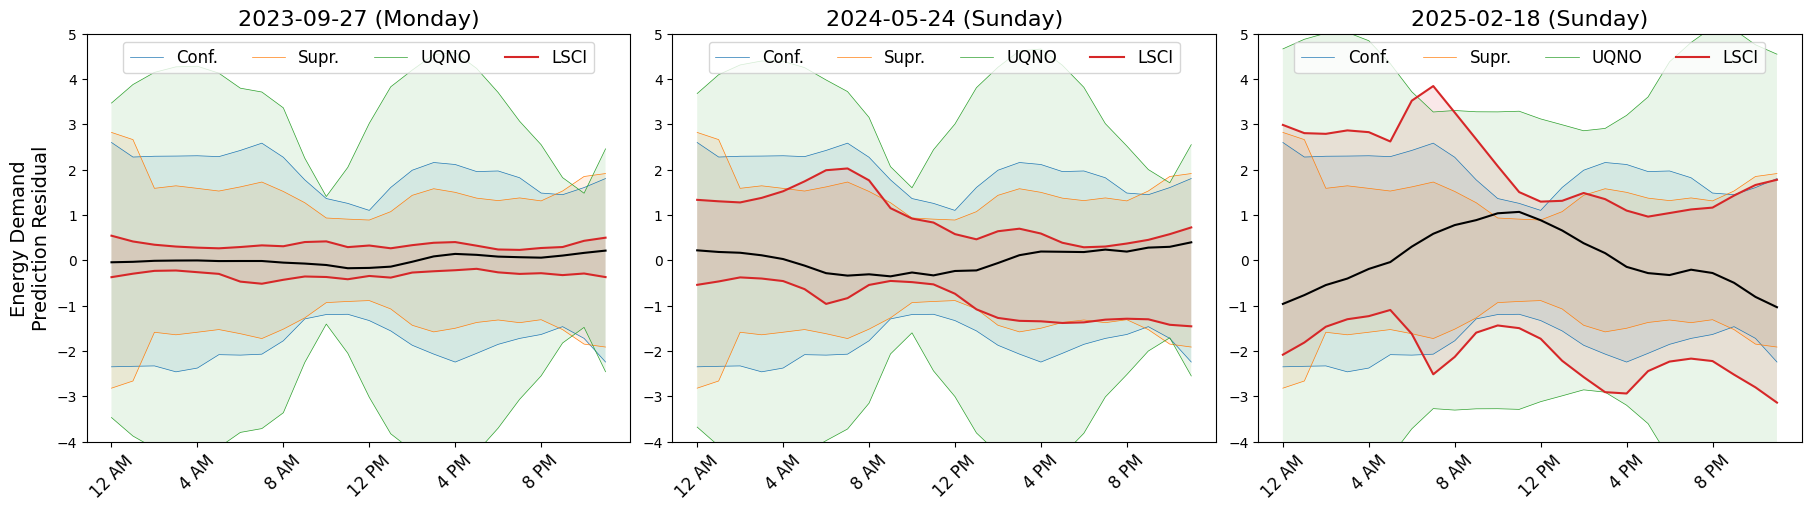

In [16]:
### examples
fig, ax = plt.subplots(1, 3, constrained_layout = True, figsize = (18, 5))

n1, n2, n3 = 11, 647, 904
n1, n2, n3 = 1, 2, 3
n1, n2, n3 = 510, 750, 1020

lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[n1].squeeze(), state, alpha, 2000, gamma1)
uqno_lower, uqno_upper = uqn1_lower[n1], uqn1_upper[n1]

ax[0].set_ylim(-4, 5)
ax[0].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5, label = 'Conf.')
ax[0].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
ax[0].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5, label = 'Supr.')
ax[0].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
ax[0].plot(uqno_upper, c = 'C2', lw = 0.5, label = 'UQNO')
ax[0].plot(uqno_lower, c = 'C2', lw = 0.5)
ax[0].plot(lsc1_upper, c = 'C3', lw = 1.5, label = 'LSCI')
ax[0].plot(lsc1_lower, c = 'C3', lw = 1.5)
ax[0].plot(rtest[n1], c = 'black')

s = np.arange(24)
ax[0].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)

lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[n2].squeeze(), state, alpha, 2000, gamma1)
uqno_lower, uqno_upper = uqn1_lower[n2], uqn1_upper[n2]

ax[1].set_ylim(-4, 5)
ax[1].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5, label = 'Conf.')
ax[1].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
ax[1].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5, label = 'Supr.')
ax[1].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
ax[1].plot(uqno_upper, c = 'C2', lw = 0.5, label = 'UQNO')
ax[1].plot(uqno_lower, c = 'C2', lw = 0.5)
ax[1].plot(lsc1_upper, c = 'C3', lw = 1.5, label = 'LSCI')
ax[1].plot(lsc1_lower, c = 'C3', lw = 1.5)
ax[1].plot(rtest[n2], c = 'black')

s = np.arange(24)
ax[1].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)


lsc1_lower, lsc1_upper = lsci.lsci_band(xtest[n3].squeeze(), state, alpha, 2000, gamma1)
uqno_lower, uqno_upper = uqn1_lower[n3], uqn1_upper[n3]

ax[2].set_ylim(-4, 5)
ax[2].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5, label = 'Conf.')
ax[2].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
ax[2].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5, label = 'Supr.')
ax[2].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
ax[2].plot(uqno_upper, c = 'C2', lw = 0.5, label = 'UQNO')
ax[2].plot(uqno_lower, c = 'C2', lw = 0.5)
ax[2].plot(lsc1_upper, c = 'C3', lw = 1.5, label = 'LSCI')
ax[2].plot(lsc1_lower, c = 'C3', lw = 1.5)
ax[2].plot(rtest[n3], c = 'black')

s = np.arange(24)
ax[2].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
ax[2].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
ax[2].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
ax[2].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)


ax[0].set_xticks(s[::4], hours[::4], rotation=45, fontsize = 12)
ax[1].set_xticks(s[::4], hours[::4], rotation=45, fontsize = 12)
ax[2].set_xticks(s[::4], hours[::4], rotation=45, fontsize = 12)

ax[0].set_ylabel('Energy Demand\nPrediction Residual', fontsize = 14)

ax[0].set_title(f'{np.datetime64(dts[ntrain + nval + n1], "D")} (Monday)', fontsize = 16)
ax[1].set_title(f'{np.datetime64(dts[ntrain + nval + n2], "D")} (Sunday)', fontsize = 16)
ax[2].set_title(f'{np.datetime64(dts[ntrain + nval + n3], "D")} (Sunday)', fontsize = 16)

ax[0].legend(ncol = 4, fontsize = 12, loc = 'upper center')
ax[1].legend(ncol = 4, fontsize = 12, loc = 'upper center')
ax[2].legend(ncol = 4, fontsize = 12, loc = 'upper center')
plt.show()

In [21]:
# plt.plot(yval_hat.squeeze()[800])
# plt.plot(yval.squeeze()[800])

In [22]:
# UQNO lambda estimate
yval_quant = yval.reshape(yval_quant.shape[0], -1)
ytest_quant = ytest_quant.reshape(ytest_quant.shape[0], -1)

alpha = 0.1
delta = 0.1
# m = 32*64
m = 24
tau = 20 * jnp.sqrt(-jnp.log(delta)/(2*m))
sg = jnp.abs(yval.squeeze() - yval_hat.squeeze()) / yval_quant
sg = jnp.quantile(sg, 1-alpha+tau, axis = (1))
nval = sg.shape[0]

adj_alpha = 1 - jnp.ceil((nval + 1) * (delta - jnp.exp(-2*m*tau**2)))/nval
lam_uqno = jnp.quantile(sg, adj_alpha) * 1/10
lam_uqno

Array(1.8322151, dtype=float32)

In [23]:
nproj = 24
gamma1 = 0.1
gamma2 = 0.05
alpha = 0.1
nval = xval.shape[0]
alpha1 = 1 - jnp.ceil((1-alpha) * (gamma1*nval + 1))/(gamma1*nval)

lsc1_rc = []
lsc2_rc = []
conf_rc = []
supr_rc = []
uqn1_rc = []

lsc1_width = []
lsc2_width = []
conf_width = []
supr_width = []
uqn1_width = []

yval = yval.reshape(yval.shape[0], -1)
yval_hat = yval_hat.reshape(yval_hat.shape[0], -1)
pca_state = lsci.phi_state(yval, yval_hat, nproj)

rval = (yval - yval_hat).squeeze()
rtest = (ytest - ytest_hat).squeeze()

conf_lower, conf_upper = conf.conf_band(rval, pca_state, alpha)
supr_lower, supr_upper = supr.supr_band(rval, alpha)
uqn1_lower, uqn1_upper = uqno.uqno_band(ytest_quant, lam_uqno)

for i in trange(0, ytest.shape[0]):
# for i in trange(0, 100):
    
    # LSCI
    lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha1, gamma1, 2000)
    lsc1_rc.append(risk(lsc1_lower, lsc1_upper, rtest[i]))
    lsc1_width.append(jnp.median(lsc1_upper - lsc1_lower))
    
    # LSCI
    lsc2_lower, lsc2_upper = lsci.lsci(rval, xval, xtest[i], pca_state, alpha1, gamma2, 2000)
    lsc2_rc.append(risk(lsc2_lower, lsc2_upper, rtest[i]))
    lsc2_width.append(jnp.median(lsc2_upper - lsc2_lower))
    
    # CONF 
    conf_rc.append(risk(conf_lower, conf_upper, rtest[i]))
    conf_width.append(jnp.mean(conf_upper - conf_lower))
    
    # SUPR
    supr_rc.append(risk(supr_lower, supr_upper, rtest[i]))
    supr_width.append(jnp.mean(supr_upper - supr_lower))
    
    # UQNO
    uqn1_rc.append(risk(uqn1_lower[i], uqn1_upper[i], rtest[i]))
    uqn1_width.append(jnp.mean(uqn1_upper[i] - uqn1_lower[i]))

    
conf_rc = np.array(conf_rc)
supr_rc = np.array(supr_rc)
uqn1_rc = np.array(uqn1_rc)
lsc1_rc = np.array(lsc1_rc)
lsc2_rc = np.array(lsc2_rc)

conf_width = np.array(conf_width)
supr_width = np.array(supr_width)
uqn1_width = np.array(uqn1_width)
lsc1_width = np.array(lsc1_width)
lsc2_width = np.array(lsc2_width)

  0%|          | 0/1021 [00:00<?, ?it/s]

In [24]:
noise_sd = np.std(rtest, axis = 1)[:conf_rc.shape[0]]

risk_control = np.mean(conf_rc >= 0.99), \
               np.mean(supr_rc >= 0.99), \
               np.mean(uqn1_rc >= 0.99), \
               np.mean(lsc1_rc >= 0.99), \
               np.mean(lsc2_rc >= 0.99)

width = np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = 0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [25]:
np.set_printoptions(suppress=True)
print(np.round(metrics, 3))

[[ 0.96  -0.552  3.813  0.   ]
 [ 0.919 -0.704  3.102  0.   ]
 [ 0.93  -0.532  4.308  0.587]
 [ 0.938 -0.263  1.878  0.716]
 [ 0.925 -0.273  1.711  0.728]]


In [26]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

0.960 & -0.552 & 3.813 & 0.000 \\
0.919 & -0.704 & 3.102 & 0.000 \\
0.930 & -0.532 & 4.308 & 0.587 \\
0.938 & -0.263 & 1.878 & 0.716 \\
0.925 & -0.273 & 1.711 & 0.728 \\


In [28]:
oracle_rc = []
oracle_width = []
for i in trange(0, ytest.shape[0]):
    
    # Oracle    
    oracle_lower = jnp.min(rtest[i]) * jnp.ones((24,)) - 1e-7
    oracle_upper = jnp.max(rtest[i]) * jnp.ones((24,)) + 1e-7
    oracle_rc.append(risk(oracle_lower, oracle_upper, rtest[i]))
    oracle_width.append(jnp.mean(oracle_upper - oracle_lower))

oracle_rc = np.array(oracle_rc)
oracle_width = np.array(oracle_width)

  0%|          | 0/1021 [00:00<?, ?it/s]

In [29]:
noise_sd = np.std(rtest, axis = 1)

risk_control = np.mean(oracle_rc >= 0.99), \
               np.mean(conf_rc >= 0.99), \
               np.mean(supr_rc >= 0.99), \
               np.mean(uqn1_rc >= 0.99), \
               np.mean(lsc1_rc >= 0.99), \
               np.mean(lsc2_rc >= 0.99)

width = np.mean(oracle_width), \
        np.mean(conf_width), \
        np.mean(supr_width), \
        np.mean(uqn1_width), \
        np.mean(lsc1_width), \
        np.mean(lsc2_width)

risk_cor = 0, \
           np.corrcoef([noise_sd, conf_rc])[0,1], \
           np.corrcoef([noise_sd, supr_rc])[0,1], \
           np.corrcoef([noise_sd, uqn1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc1_rc])[0,1], \
           np.corrcoef([noise_sd, lsc2_rc])[0,1]

width_cor = np.corrcoef([noise_sd, oracle_width])[0,1], \
            0, \
            0, \
            np.corrcoef([noise_sd, uqn1_width])[0,1], \
            np.corrcoef([noise_sd, lsc1_width])[0,1], \
            np.corrcoef([noise_sd, lsc2_width])[0,1]

metrics = np.array([risk_control, risk_cor, width, width_cor]).T

In [30]:
for i in range(metrics.shape[0]):
    for j in range(metrics.shape[1]):
        val = f'{np.round(metrics[i,j], 3):.3f}'
        if j < 3:
            val += ' & '
            print(val, end = '')
        else:
            val += ' \\\\'
            print(val)

0.974 & 0.000 & 1.085 & 0.979 \\
0.960 & -0.552 & 3.813 & 0.000 \\
0.919 & -0.704 & 3.102 & 0.000 \\
0.930 & -0.532 & 4.308 & 0.587 \\
0.938 & -0.263 & 1.878 & 0.716 \\
0.925 & -0.273 & 1.711 & 0.728 \\


In [561]:
arclen = jnp.sum(jnp.diff(rtest, axis = 1)**2, axis = 1)

In [143]:
# plt.plot(2 * noise_sd)
# plt.plot(lsc1_width)
# plt.plot(uqn1_width)
# plt.plot(conf_width)
# plt.plot(supr_width)
# jnp.argmin(arclen), jnp.argmax(arclen)

In [105]:
hours = []
for i in range(24):
    j = i
    if i % 12 == 0: j = 12
        
    if i < 12:
        hours.append(f'{j} ' + 'AM') 
    elif i == 12:
        hours.append(f'{j} ' + 'PM') 
    else:
        hours.append(f'{j-12} ' + 'PM')

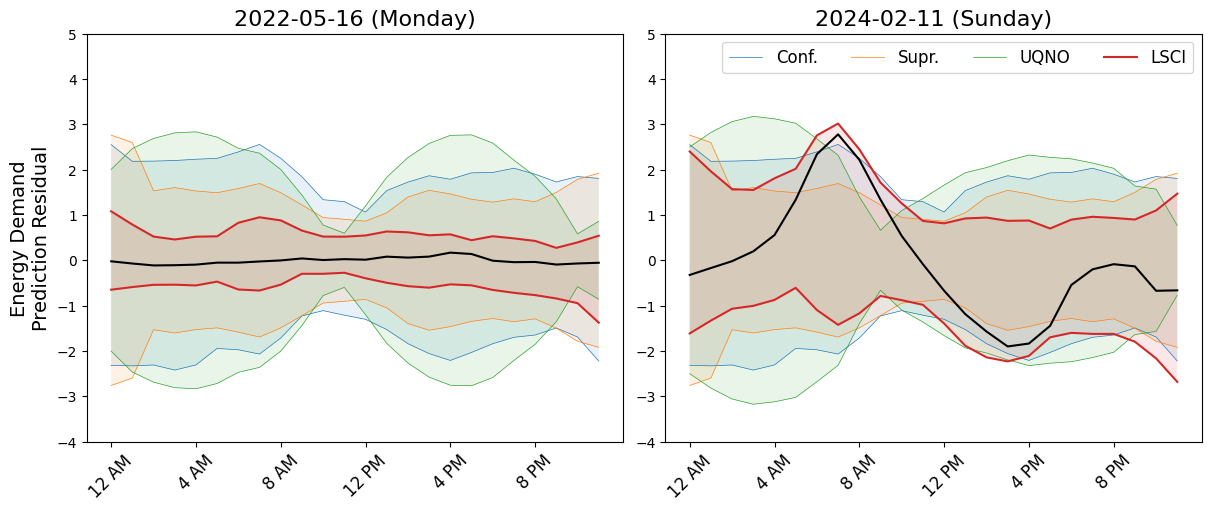

In [142]:
### examples
fig, ax = plt.subplots(1, 2, constrained_layout = True, figsize = (12, 5))

n1 = 11
lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[n1], pca_state, alpha1, gamma1, 2000)
uqno_lower, uqno_upper = uqn1_lower[n1], uqn1_upper[n1]

ax[0].set_ylim(-4, 5)
ax[0].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5)
ax[0].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
ax[0].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5)
ax[0].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
ax[0].plot(uqno_upper, c = 'C2', lw = 0.5)
ax[0].plot(uqno_lower, c = 'C2', lw = 0.5)
ax[0].plot(lsc1_upper, c = 'C3', lw = 1.5)
ax[0].plot(lsc1_lower, c = 'C3', lw = 1.5)
ax[0].plot(rtest[n1], c = 'black')

s = np.arange(24)
ax[0].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
ax[0].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)

n2 = 647
lsc1_lower, lsc1_upper = lsci.lsci(rval, xval, xtest[n2], pca_state, alpha1, gamma1, 2000)
uqno_lower, uqno_upper = uqn1_lower[n2], uqn1_upper[n2]

ax[1].set_ylim(-4, 5)
ax[1].plot(conf_upper.squeeze(), c = 'C0', lw = 0.5, label = 'Conf.')
ax[1].plot(conf_lower.squeeze(), c = 'C0', lw = 0.5)
ax[1].plot(supr_upper.squeeze(), c = 'C1', lw = 0.5, label = 'Supr.')
ax[1].plot(supr_lower.squeeze(), c = 'C1', lw = 0.5)
ax[1].plot(uqno_upper, c = 'C2', lw = 0.5, label = 'UQNO')
ax[1].plot(uqno_lower, c = 'C2', lw = 0.5)
ax[1].plot(lsc1_upper, c = 'C3', lw = 1.5, label = 'LSCI')
ax[1].plot(lsc1_lower, c = 'C3', lw = 1.5)
ax[1].plot(rtest[n2], c = 'black')

s = np.arange(24)
ax[1].fill_between(s, conf_lower.squeeze(), conf_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, supr_lower.squeeze(), supr_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, uqno_lower.squeeze(), uqno_upper.squeeze(), alpha = 0.1)
ax[1].fill_between(s, lsc1_lower.squeeze(), lsc1_upper.squeeze(), alpha = 0.1)
 
ax[0].set_xticks(s[::4], hours[::4], rotation=45, fontsize = 12)
ax[1].set_xticks(s[::4], hours[::4], rotation=45, fontsize = 12)

ax[0].set_ylabel('Energy Demand\nPrediction Residual', fontsize = 14)

ax[0].set_title(f'{np.datetime64(dts[ntrain + nval + n1], "D")} (Monday)', fontsize = 16)
ax[1].set_title(f'{np.datetime64(dts[ntrain + nval + n2], "D")} (Sunday)', fontsize = 16)

ax[1].legend(ncol = 4, fontsize = 12)
plt.show()